In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

from torchview import draw_graph
from IPython.display import display, HTML

from common import h5dataset, model_dnn, onnxexporter, trainer_gan

class Discriminator(nn.Module):
    def __init__(self, name: str, input_size : int, embedding_size :int, hidden_size :list, output_size :int):
        super(Discriminator, self).__init__()
        self.name = name + "_" + "_".join(map(str, hidden_size)) + "_dnn"
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.flat = nn.Flatten()
        dim_in = input_size * embedding_size + 9 # 9 for action one-hot encoding
        layers = []
        for h in hidden_size:
            layers.append(nn.Linear(dim_in, h))
            layers.append(nn.ReLU())
            dim_in = h
        layers.append(nn.Linear(dim_in, output_size))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, state, action) -> torch.Tensor:
        x = self.forward_embedded(state)
        x = self.forward_layers(torch.cat((x, action), dim=1))
        return x
    
    def forward_embedded(self, x) -> torch.Tensor:
        x = self.embedding(x)
        x = self.flat(x)
        return x
    
    def forward_layers(self, x) -> torch.Tensor:
        x = self.layers(x)
        return x

    

In [2]:
# Plot model graph
model = model_dnn.ModelDNN(
    name="JassGanGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[1024, 512, 256, 128],
    output_size=9,
)
model_graph = draw_graph(model, torch.zeros(1, 72).long(), show_shapes=True)

discriminator = Discriminator(
    name="JassGanDisc",
    input_size=72,
    embedding_size=13,
    hidden_size=[1024, 512, 256, 128],
    output_size=1,
)

discriminator_graph = draw_graph(discriminator, (torch.zeros(1, 72).long(), torch.zeros(1, 9).long()), show_shapes=True)

model_svg = model_graph.visual_graph.pipe(format="svg").decode("utf-8")
discriminator_svg = discriminator_graph.visual_graph.pipe(format="svg").decode("utf-8")

display(HTML(
    f"""
    <div style="display: flex; flex-direction: row; gap: 40px;">
        <div>{model_svg}</div>
        <div>{discriminator_svg}</div>
    </div>
    """
))

In [3]:
DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

PRETRAINED_MODEL_PATH = './models/play/JassPlay_1024_512_256_128_dnn.pth'
if not os.path.exists(PRETRAINED_MODEL_PATH):
    raise FileNotFoundError(f"Pretrained model not found at {PRETRAINED_MODEL_PATH}")

MODLE_PATH = './models/play_gan_pretrained'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)

LOGS_PATH = './logs/play_gan_pretrained'
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

In [4]:

BATCH_SIZE = 256
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


model.load_state_dict(torch.load(PRETRAINED_MODEL_PATH))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
discriminator = discriminator.to(device)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()

# set up trainer
trainer = trainer_gan.TrainerGan(
    train_loader=train_loader,
    val_loader=val_loader,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [5]:
# train the model
trainer.train(NUM_EPOCHS, model, discriminator, optimizer, disc_optimizer)
torch.save(model.state_dict(), f"{MODLE_PATH}/{model.name}.pth")
torch.save(discriminator.state_dict(), f"{MODLE_PATH}/{discriminator.name}.pth")

Training Epoch 1: 100%|██████████| 69304/69304 [10:41<00:00, 108.05it/s]


Generator steps: 26245, Discriminator steps: 43059


Validation Epoch 1: 100%|██████████| 17326/17326 [01:04<00:00, 268.47it/s]


Epoch 1/10 - Generator Train Loss: 0.4299, Discriminator Train Loss: 1.0710, Generator Val Loss: 0.3796, Discriminator Val Loss: -0.0907


Training Epoch 2: 100%|██████████| 69304/69304 [10:44<00:00, 107.61it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 2: 100%|██████████| 17326/17326 [01:04<00:00, 268.09it/s]


Epoch 2/10 - Generator Train Loss: -0.0732, Discriminator Train Loss: -0.0245, Generator Val Loss: 0.4042, Discriminator Val Loss: -0.0114


Training Epoch 3: 100%|██████████| 69304/69304 [11:26<00:00, 100.89it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 3: 100%|██████████| 17326/17326 [01:05<00:00, 263.26it/s]


Epoch 3/10 - Generator Train Loss: -0.2713, Discriminator Train Loss: -0.0069, Generator Val Loss: 4.4689, Discriminator Val Loss: 0.0000


Training Epoch 4: 100%|██████████| 69304/69304 [11:13<00:00, 102.88it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 4: 100%|██████████| 17326/17326 [01:05<00:00, 264.33it/s]


Epoch 4/10 - Generator Train Loss: -1.9180, Discriminator Train Loss: -0.0054, Generator Val Loss: 0.8806, Discriminator Val Loss: -0.0264


Training Epoch 5: 100%|██████████| 69304/69304 [10:55<00:00, 105.76it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 5: 100%|██████████| 17326/17326 [01:05<00:00, 263.74it/s]


Epoch 5/10 - Generator Train Loss: 0.4916, Discriminator Train Loss: -0.0056, Generator Val Loss: -1.8813, Discriminator Val Loss: 0.0009


Training Epoch 6: 100%|██████████| 69304/69304 [10:59<00:00, 105.12it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 6: 100%|██████████| 17326/17326 [01:05<00:00, 263.24it/s]


Epoch 6/10 - Generator Train Loss: -0.2726, Discriminator Train Loss: -0.0049, Generator Val Loss: -1.1633, Discriminator Val Loss: -0.0125


Training Epoch 7: 100%|██████████| 69304/69304 [10:50<00:00, 106.49it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 7: 100%|██████████| 17326/17326 [01:05<00:00, 263.96it/s]


Epoch 7/10 - Generator Train Loss: 1.2506, Discriminator Train Loss: -0.0044, Generator Val Loss: -1.4386, Discriminator Val Loss: 0.0110


Training Epoch 8: 100%|██████████| 69304/69304 [10:55<00:00, 105.75it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 8: 100%|██████████| 17326/17326 [01:05<00:00, 262.88it/s]


Epoch 8/10 - Generator Train Loss: 0.8174, Discriminator Train Loss: -0.0044, Generator Val Loss: 9.8698, Discriminator Val Loss: -0.0051


Training Epoch 9: 100%|██████████| 69304/69304 [10:52<00:00, 106.27it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 9: 100%|██████████| 17326/17326 [01:05<00:00, 263.45it/s]


Epoch 9/10 - Generator Train Loss: 1.2033, Discriminator Train Loss: -0.0042, Generator Val Loss: 0.3582, Discriminator Val Loss: -0.0125


Training Epoch 10: 100%|██████████| 69304/69304 [10:51<00:00, 106.32it/s]


Generator steps: 11551, Discriminator steps: 57753


Validation Epoch 10: 100%|██████████| 17326/17326 [01:06<00:00, 262.30it/s]

Epoch 10/10 - Generator Train Loss: -0.8339, Discriminator Train Loss: -0.0040, Generator Val Loss: 3.6321, Discriminator Val Loss: -0.0111


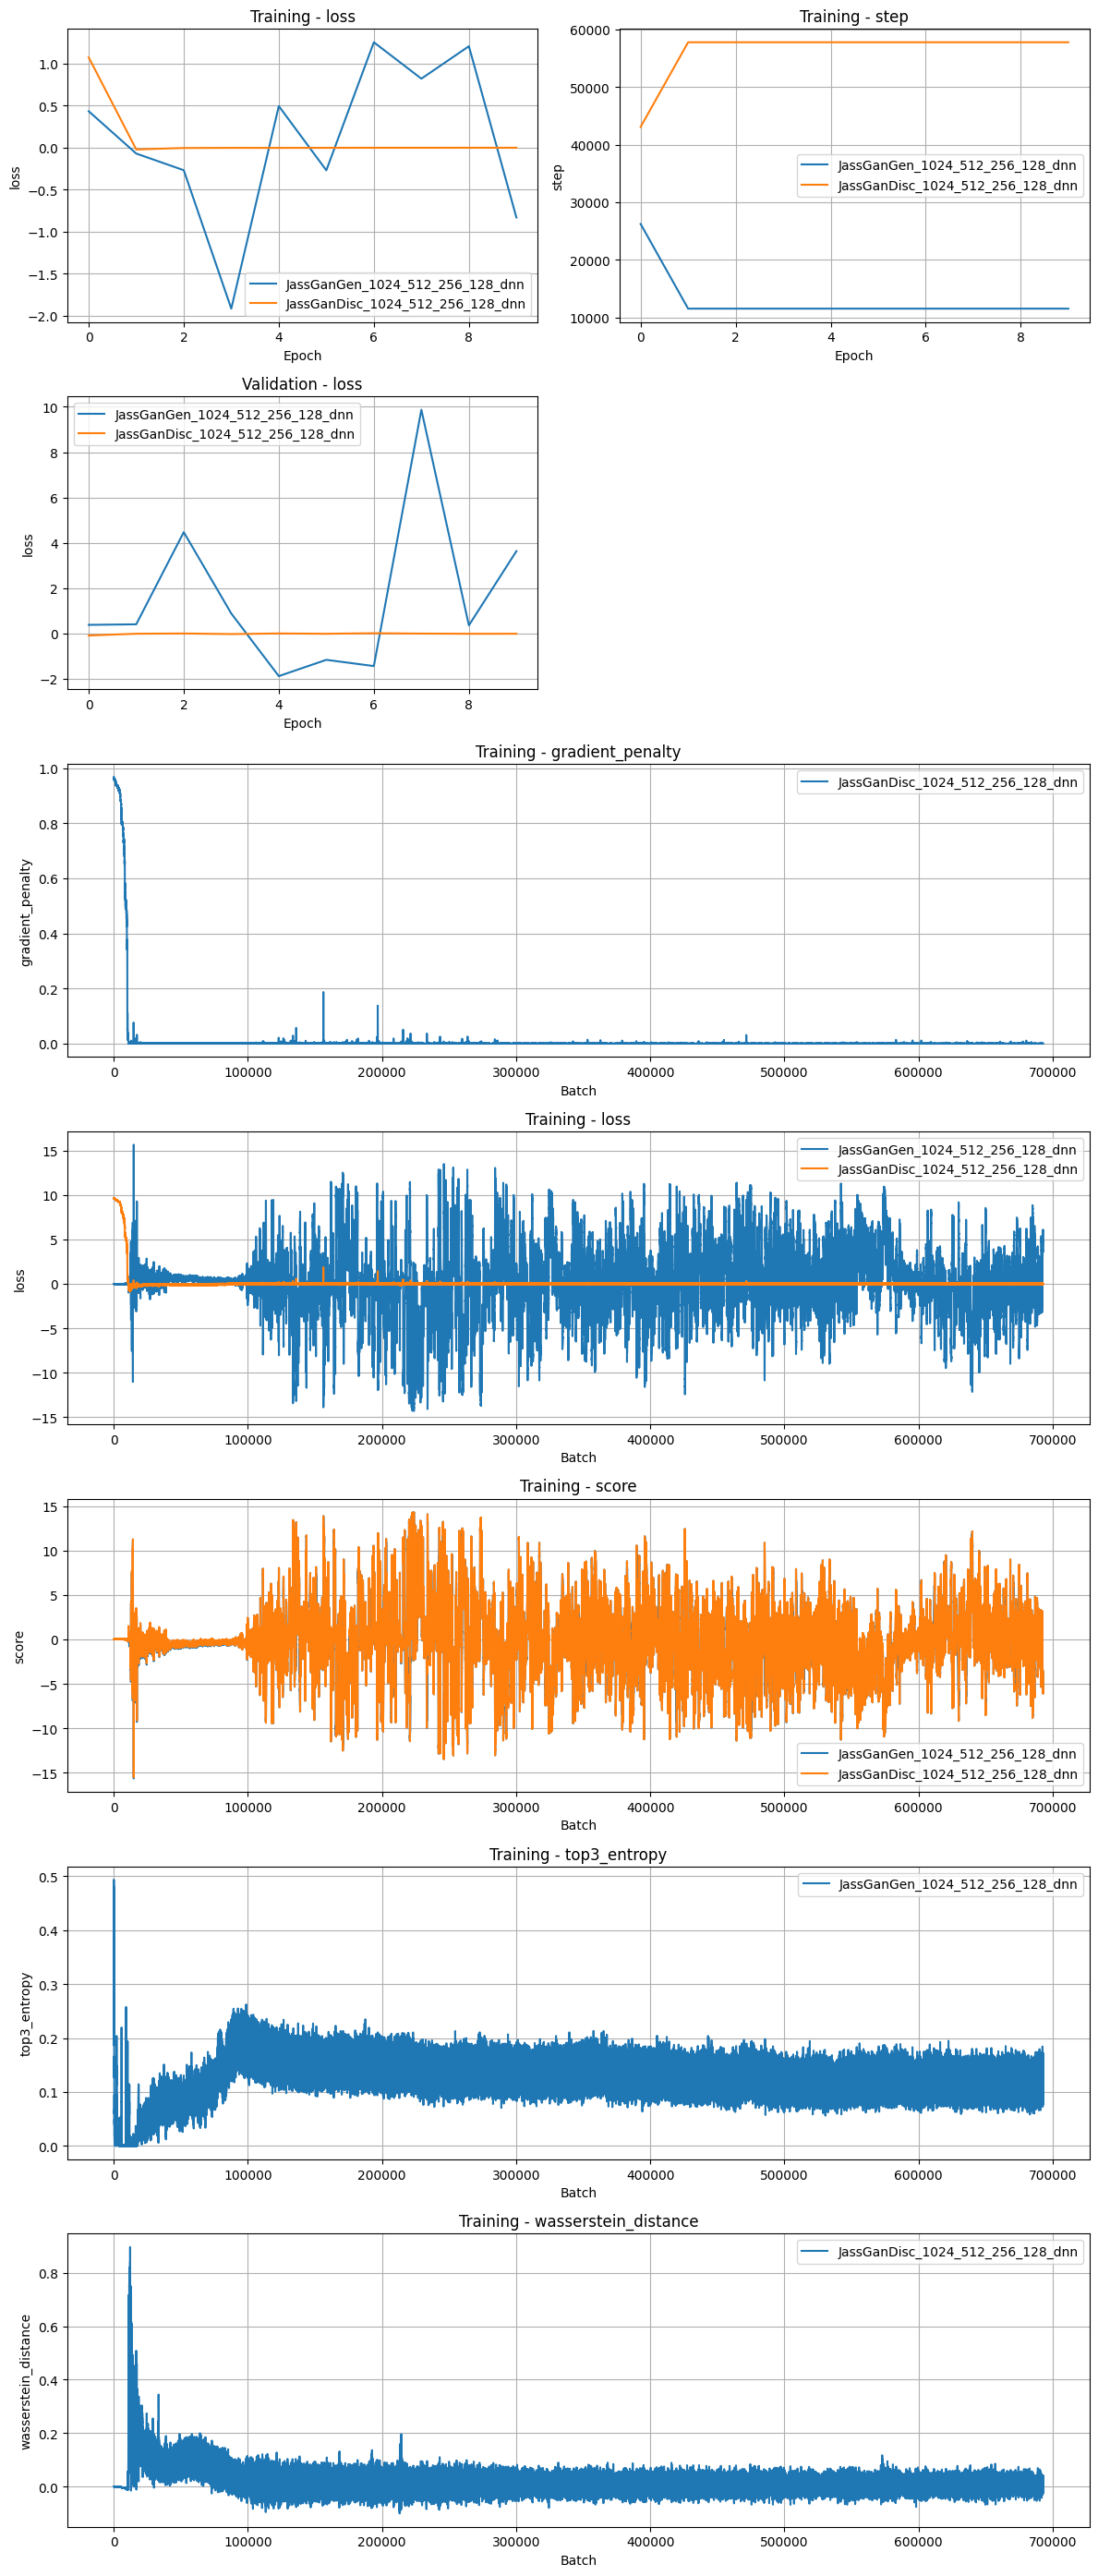

In [ ]:
# create graphs
trainer.monitor.plot()

In [10]:
trainer.monitor.dump(dump_path=LOGS_PATH, filename="monitor")

In [11]:
# export the model to ONNX
ONNX_PATH = f"{MODLE_PATH}/{model.name}.onnx"
model = model_dnn.ModelDNN(
    name="JassGanGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[1024, 512, 256, 128],
    output_size=9,
)
model.load_state_dict(torch.load(f"{MODLE_PATH}/{model.name}.pth"))
onnxexporter.onnx_exporter(
    model=model,
    decision_fn=F.log_softmax,
    in_dim=72,
    output_path=ONNX_PATH
)

Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./models/play_gan_pretrained/JassGanGen_1024_512_256_128_dnn.onnx
